In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
from keras import regularizers
from keras.callbacks import EarlyStopping
# K.tensorflow_backend._get_available_gpus()

In [38]:
# !unzip "/content/drive/MyDrive/redshift/sdss_images.zip" -d "/content"

In [2]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((72, 72))
image_size = 0
directory_root = 'sdss_images'
width=72
height=72
depth=3

In [3]:
#collecting image names
image_names = listdir('sdss_images')

In [4]:
len(image_names)

57720

In [5]:
directory = 'sdss_images/'

In [6]:
image = cv2.imread(directory + image_names[1])

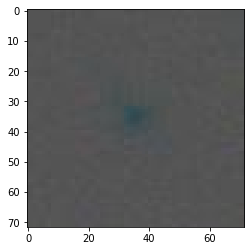

In [7]:
plt.imshow(image)

In [8]:
image_list = []
target_list = []
import re

In [9]:
# collecting image array and target array
for i in tqdm(image_names):
  image = cv2.imread(directory + i)
  image = cv2.resize(image, default_image_size)
  image_list.append(image)
  target = re.findall('(?<=_z_).*$', i)[0][:-4]
  target_list.append(float(target))
image_arr = np.array(image_list)
target_Arr = np.array(target_list)

100%|██████████| 57720/57720 [00:06<00:00, 9218.87it/s]


In [10]:
image_arr1 = np.array(image_arr, dtype=np.float16) / 225.0

In [11]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(image_arr1, target_Arr, test_size=0.3, random_state = 42)
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
print(x_train.shape)
print(y_train.shape)

[INFO] Spliting data to train, test
(40404, 72, 72, 3)
(40404,)


Simple CNN

In [40]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1,activation='linear'))

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 72, 72, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 24, 24, 64)       

In [42]:
opt = Adam(lr=0.0001)
model.compile(loss="mean_squared_error", optimizer=opt,metrics=[metrics.MeanSquaredError()])

In [43]:
earlystop = EarlyStopping(monitor='val_loss', patience=3)

In [44]:
history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS), validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BS,
                              epochs=20, verbose=1,callbacks=[earlystop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
631/631 [==============================] - 53s 83ms/step - loss: 1.9957 - mean_squared_error: 1.9957 - val_loss: 35.9782 - val_mean_squared_error: 35.9782
Epoch 2/20
631/631 [==============================] - 50s 80ms/step - loss: 0.9195 - mean_squared_error: 0.9195 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 3/20
631/631 [==============================] - 51s 82ms/step - loss: 0.6057 - mean_squared_error: 0.6057 - val_loss: 0.0584 - val_mean_squared_error: 0.0584
Epoch 4/20
631/631 [==============================] - 52s 82ms/step - loss: 0.4439 - mean_squared_error: 0.4439 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 5/20
631/631 [==============================] - 50s 80ms/step - loss: 0.3202 - mean_squared_error: 0.3202 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 6/20
631/631 [==============================] - 52s 82ms/step - loss: 0.2149 - mean_squared_error: 0.2149 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 7/20
631

In [45]:
loss = history.history['loss'][0:9]
val_loss = history.history['val_loss'][0:9]

<Figure size 432x288 with 0 Axes>

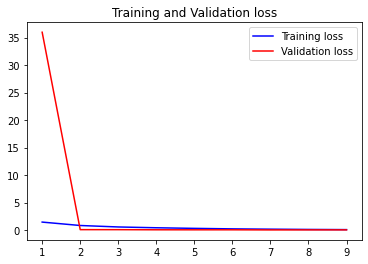

<Figure size 432x288 with 0 Axes>

In [46]:
epochs = range(1, 9 + 1)
#Train and validation accuracy
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prediction


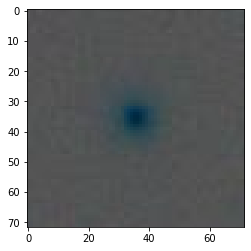

In [51]:
image = cv2.imread(directory + image_names[3])
plt.imshow(image)

In [50]:
print('redshift value - ',y_train[3])

redshift value -  0.590735


In [49]:
print('Predicted photoometric redshift - ',model.predict(x_train[3].reshape(1,72,72,3)))

Predicted photoometric redshift -  [[0.59490615]]


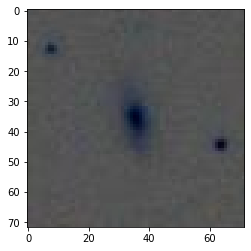

In [52]:
image = cv2.imread(directory + image_names[4])
plt.imshow(image)

In [53]:
print('redshift value - ',y_train[4])

redshift value -  0.0822162


In [54]:
print('Predicted photoometric redshift - ',model.predict(x_train[4].reshape(1,72,72,3)))

Predicted photoometric redshift -  [[0.04285297]]


DenseNet - 121

In [23]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.models import Model


base_model = DenseNet121(weights='imagenet', input_shape=(72, 72, 3),include_top=False)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=prediction)

# freezing all layers of dense net 
for layer in base_model.layers:
    layer.trainable = False


In [24]:
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0001),metrics=[metrics.MeanSquaredError()])
BS = 64
earlystop = EarlyStopping(monitor='loss', patience=3)

In [25]:
history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS), validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BS,
                              epochs=13, verbose=1,callbacks=[earlystop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/13
631/631 [==============================] - 67s 98ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 2/13
631/631 [==============================] - 58s 92ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 3/13
631/631 [==============================] - 58s 92ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 4/13
631/631 [==============================] - 58s 91ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 5/13
631/631 [==============================] - 58s 92ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 6/13
631/631 [==============================] - 57s 91ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 7/13
631/6

In [26]:
loss = history.history['loss'][0:12]
val_loss = history.history['val_loss'][0:12]

<Figure size 432x288 with 0 Axes>

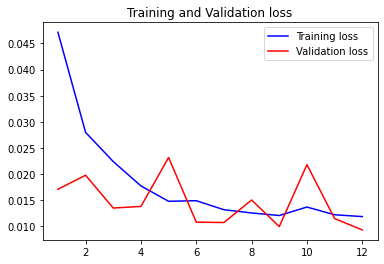

<Figure size 432x288 with 0 Axes>

In [27]:
epochs = range(1, 12 + 1)
#Train and validation accuracy
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

In [30]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
